<a href="https://colab.research.google.com/github/TravelingEngineer/Sandbox/blob/master/Training_Rev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install dependencies**

In [1]:
!pip install git+https://github.com/jameslyons/python_speech_features.git

  Cloning https://github.com/jameslyons/python_speech_features.git to /tmp/pip-req-build-9MSn5g
  Running setup.py bdist_wheel for python-speech-features ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-wsc1F6/wheels/37/1f/0e/01b5393897b85f27e49a2c823d6efbbe71f480a34cdb3a84c2
Successfully built python-speech-features


In [2]:
#from gammatone import gtgram
from python_speech_features import mfcc
from python_speech_features import logfbank
from python_speech_features import fbank
from python_speech_features import delta

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


**Import Libraries and Methods**

In [0]:
from __future__ import division #import python 3 updates for floating point division
from __future__ import print_function

import os
import math

from IPython.display import Audio
from scipy.io import wavfile
from scipy import signal
from matplotlib import cm
from matplotlib import gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

import datetime
import numpy as np
from numpy import mean, sqrt, square, arange

import pandas as pd
from sklearn import metrics

#tensorflow specific libraries
import tensorflow as tf
from tensorflow.python.data import Dataset
#tf.enable_eager_execution() #tf.placeholder not compatible with eager execution, used for autoencoder

tf.logging.set_verbosity(tf.logging.ERROR) #sets threshold for what is logged in tenserflow
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

**Google Drive Configuration **

In [4]:
from google.colab import auth
from google.colab import files
#email Collins.AE6@gmail.com
#pswd machine_learning610
from google.colab import drive
drive.mount('/content/drive')

#Upload data from GoogleDrive
gDrive= '/content/drive/My Drive/Training_Database/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#check for data
!ls "/content/drive/My Drive/Training_Database"

 Anechoic_Audio_16_44k_Mono.wav        gaussian_database3
 data%2Fspeech_commands_v0.02.tar.gz  'old audio roughwork'
 female_counting_16.wav		       speech_convolved_normalized.wav


**Write Audio to Array**

In [6]:
#Audio files must be .wave 16-bit 44 kHz format
file_speech = gDrive+'Anechoic_Audio_16_44k_Mono.wav'
fs, sig_speech = wavfile.read(file_speech)
#fs_original, sig_speech = wavfile.read(file_speech)
sig_speech = sig_speech.astype(np.float32) #converts wavfile from read only to write access default float is 64, specify 32 for tensorflow
sig_speech /= 2**15 #normalizes 16 bit wavefile
#sig_speech=sig_speech[:,0] #discard stereo to create mono audio, use carefully!
#sig_speech = sig_speech[np.newaxis] #shape array for convolution with gaussian impulse
sig_speech

array([ 1.5258789e-04,  2.4414062e-04,  1.2207031e-04, ...,
       -9.1552734e-05, -1.5258789e-04, -6.1035156e-05], dtype=float32)

**If resampling required on wav file**

In [0]:
#fs=44100 #standardized sampling frequency [Hz]
#sig_speech=signal.resample(sig_speech, int(sig_speech.shape[0]*fs/fs_original), window='boxcar') #boxcar is rectangular


In [0]:
#sig_speech_normalized = sig_speech/np.max(np.abs(sig_speech))  
#sig_speech_normalized *= 2**15
#sig_speech_normalized = sig_speech_normalized.astype(np.int16)

In [0]:
#outfile = 'ZOOM0005_LR_16_sampled_down.wav'
#wavfile.write(outfile, fs, sig_speech_normalized)
#files.download(outfile)

**Extract random 3s clip from audio array**

In [0]:
#segment_length=3 #duration in [s] of random segment from audio file
#random_start=np.random.uniform(low=0,high=len(sig_speech)/fs-segment_length) #want to pull 30 random starts from audio file but get error size=(1,30)
#random_start_int=random_start.astype(np.int)
#random_start_int=random_start_int[:,np.newaxis]
#test=random_start_int*fs
#sig_speech_sample=sig_speech[random_start_int*fs:(random_start_int*fs+segment_length*fs)] #TypeError: only integer scalar arrays can be converted to a scalar index
#random_start_int.shape
#sig_speech_sample(1)

#Grab a 3 sec chunk from the available data
Segment_length=3*fs
Random_Start=int(np.random.uniform(0,len(sig_speech)-Segment_length))
sig_speech_sample=sig_speech[Random_Start:(Random_Start+Segment_length)]

In [10]:
#play Audio for check
Audio(sig_speech_sample, rate=fs)
#len(sig_speech_sample)

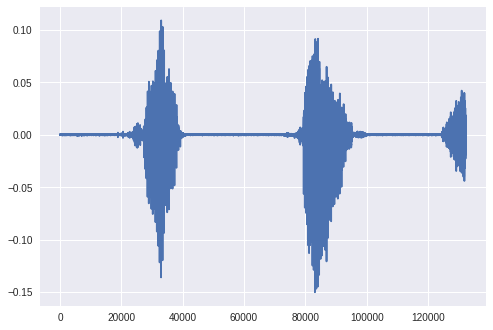

In [11]:
#display Audio for check
plt.plot(sig_speech_sample)
plt.show()

**MFSC configuration**

In [12]:
sig_speech_sample.shape

(132300,)

In [0]:
mfsc=logfbank(sig_speech_sample,
         fs,
         winlen=0.04, #40 ms window
         winstep=0.04/8, #12.5% overlap
         nfilt=40, #number of triangular filter banks
         nfft=2048, #N-point FFT on each frame 246 or 512 used 
         lowfreq=20,
         highfreq=20000,
         preemph=0) #historical balences frequency spectrum since high frequencies have 
                       #smaller magnitudes, than low frequencies 

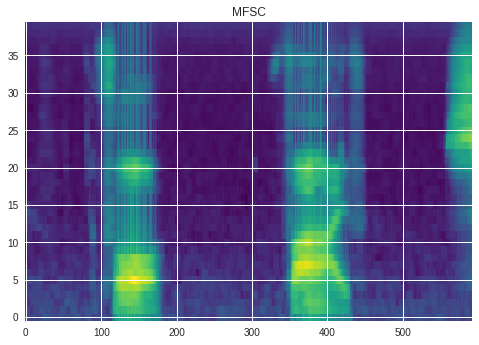

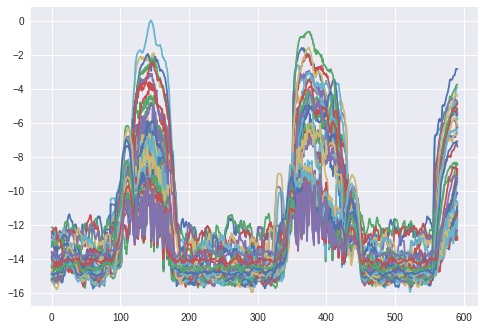

In [14]:

ig, ax = plt.subplots()
mfsc_feature= np.swapaxes(mfsc, 0 ,1)
cax = ax.imshow(mfsc_feature, interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax.set_title('MFSC')
#Showing mfsc_data
plt.show()
plt.plot(mfsc)
plt.show()

**Signal to Noise Ratio Check**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


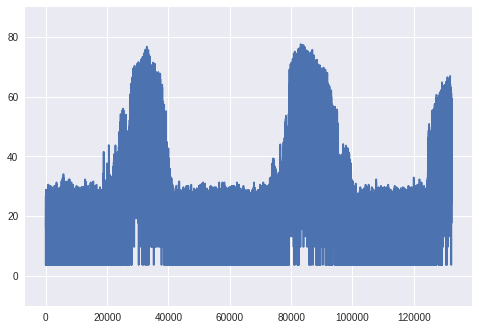

4918

In [15]:
dB_calibration = (20e-6)#*(math.sqrt(2)) #manually adjusted 20*10^-6
dB_sig_speech_sample = 20*np.log10(abs(sig_speech_sample)/dB_calibration) #convert wav recording to dB
dB_sig_speech_sample
#sig_speech_sample
plt.ylim(-10,90)
plt.plot(dB_sig_speech_sample)
plt.show()
np.isneginf(dB_sig_speech_sample).sum() #number of zero crossings
                                        #bottom of what is plotted is point just before zero

**Spectrogram Config**

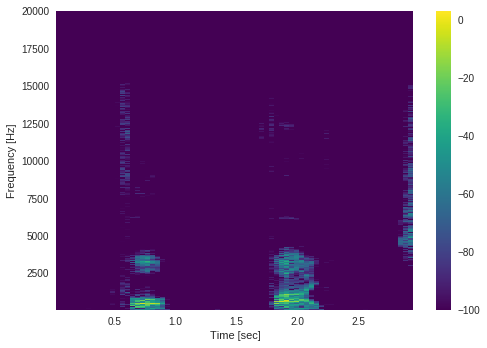

In [16]:
f, t, Sxx = signal.spectrogram(
    sig_speech_sample, 
    fs, 
    window=('hann'), #FFT window
    nperseg=2048, #length of window, default is 256, with 44[kHz] sample rate gives 5[ms] window, 2048 is 40 [ms]
    noverlap=None, #default window overlap is nperseg/8 which is ~12.5% overlap
    nfft=None,     #no padding
    detrend='constant', #if low frequency drift offset change
    return_onesided=True, #for hilbert when you have a complex raw signal
    scaling='density', #use density from broadband noise, tonal noise use spectrum
    axis=-1, #align with time access, raw mono audio is 1-D
    mode='psd')

#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
dB_spectrum = 20*np.log10(Sxx/dB_calibration)
cmap = plt.get_cmap('viridis') #winter, summer, grey, hot
plt.pcolormesh(t, f, dB_spectrum, cmap=cmap, vmin=-100) # norm=LogNorm(vmin=Sxx.min(),vmax=Sxx.max() Sxx.min() 10**-8
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(50,20000)
plt.show()

**Generate Exponential Decay Curve With White Noise**

In [17]:
framerate = 44100 #match sample frequency of wav file [Hz]
length = 3 #duration in [s]
t = np.linspace(0,length,length*framerate)
t = t[np.newaxis]

rt=np.linspace(0.25, 2.5, num=20) #creates 1-D array #logspace np.log10(0.2) np.log10(2.5)
tau=rt/4  
tau = tau[:,np.newaxis] #slices Tau 
data=np.exp(-t/tau)
#data.shape
#data.size
noise = np.random.normal(0, 1, t.size) #random samples from a gaussian distribution, use full size of t
noise /= np.max(noise) #normalizes gaussian noise 
gaussian_impulse= data*noise
#tau
tau.shape

(20, 1)

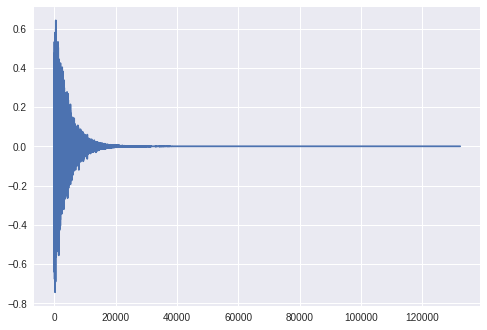

In [18]:
plt.plot(gaussian_impulse[1])
#plt.ylabel('some numbers')
plt.show()

**Convolution  of Audio File Segments with Generated Decay Curves**

In [0]:
sig_speech_sample = sig_speech_sample[np.newaxis] #shape array for convolution with gaussian impulse
speech_convolved = signal.fftconvolve(sig_speech_sample,gaussian_impulse)

In [20]:
Audio(speech_convolved[0], rate=fs)

In [37]:
speech_convolved.shape

(20, 264599)

**Output Files**

In [0]:
#os.mkdir(gDrive+'gaussian_database3')
#for rt, speech_con in zip(rt,speech_convolved): #pair Rt to speech_convolved
#  speech_con_normalized = speech_con/np.max(np.abs(speech_con))  
#  speech_con_normalized *= 2**15
#  speech_con_normalized = speech_con_normalized.astype(np.int16)

#  outfile = gDrive+'gaussian_database/speech_con_norm_{rt:g}_s.wav' #format name to include RT value
#  wavfile.write(outfile, fs, speech_con_normalized)
#files.download(outfile)

**Autoencoder Config**

In [23]:
264599/1024

258.3974609375

In [0]:
# size of encoded representations
encoding_dim = 1024 #1024 floats -> compression factor 258.4, w/ input 264599 float convolved audio file

# input placeholder
input_initalization = Input(shape=(264599,))
# "encoded" is representation of input
encoded = Dense(encoding_dim, activation='relu')(input_initalization)

#dense layer with regularizer (sparsity constraint)
#encoded = Dense(encoding_dim, activation='relu',
               #activity_regularizer=regularizers.l1(10e-5))(input_img)
# "decoded" is lossy reconstruction of input
decoded = Dense(264599, activation='sigmoid')(encoded)

#this model maps an input to reconstruction represenation
autoencoder = Model(input_initalization,decoded)
#this model maps an input to encoded represenation
encoder = Model(input_initalization,encoded)
#create a placeholder for encoded (1024-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
#create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

**Optimizer Configuration**

In [0]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') #optimizer options adam, adadelta

**Partition dataset into training and test sets**

In [0]:
# first 15 files (out of 20) for training
training_examples = speech_convolved[0:9,:] #grabs first part of data
training_targets = speech_convolved[10:15,:] #grabs end part of data

Autoencoder training

In [43]:
#training for 5 epochs
autoencoder.fit(training_examples, training_examples,
               epochs=5,
               batch_size=256,
               shuffle=True,
               validation_data=(training_targets, training_targets))

Train on 9 samples, validate on 5 samples
Epoch 1/5


FailedPreconditionError: ignored